# Import and Init

In [1]:
!pip install keras_cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.1/803.1 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 47.0 MB/s eta 0:00:00


In [2]:
!pip install cmake --upgrade
!pip install sklearn --upgrade
!git clone --recursive https://github.com/dmlc/xgboost
%cd /content/xgboost
!mkdir build
%cd build
!cmake .. -DUSE_CUDA=ON
!make -j4
%cd /content/xgboost/python-package
!python setup.py install --use-cuda --use-nccl
!/opt/bin/nvidia-smi
!pip install shap

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'xgboost'...
remote: Enumerating objects: 65199, done.
remote: Counting objects: 100% (11273/11273), done.
remote: Compressing objects: 100% (957/957), done.
remote: Total 65199 (delta 10559), reused 10351 (delta 10312), pack-reused 53926
Receiving objects: 100% (65199/65199), 25.32 MiB | 25.73 MiB/s, done.
Resolving deltas: 100% (44552/44552), done.
Submodule 'dmlc-core' (https://github.com/dmlc/dmlc-core) registered for path 'dmlc-core'
Submodule 'gputreeshap' (https://github.com/rapidsai/gputre

Using TensorFlow backend
Mounted at /gdrive
350926856/350926856 [==============================] - 1s 0us/step
Epoch 1/200
376/376 [==============================] - 136s 166ms/step - loss: 0.5315 - accuracy: 0.7498 - val_loss: 0.4367 - val_accuracy: 0.7963
Epoch 2/200
376/376 [==============================] - 46s 122ms/step - loss: 0.3485 - accuracy: 0.8501 - val_loss: 0.3485 - val_accuracy: 0.8362
Epoch 3/200
376/376 [==============================] - 45s 119ms/step - loss: 0.2929 - accuracy: 0.8711 - val_loss: 0.2899 - val_accuracy: 0.8682
Epoch 4/200
376/376 [==============================] - 45s 119ms/step - loss: 0.2542 - accuracy: 0.8894 - val_loss: 0.2577 - val_accuracy: 0.8828
Epoch 5/200
376/376 [==============================] - 45s 119ms/step - loss: 0.2214 - accuracy: 0.9064 - val_loss: 0.3333 - val_accuracy: 0.8575
Epoch 6/200
376/376 [==============================] - 45s 119ms/step - loss: 0.1893 - accuracy: 0.9264 - val_loss: 0.2173 - val_accuracy: 0.9095
Epoch 7/200


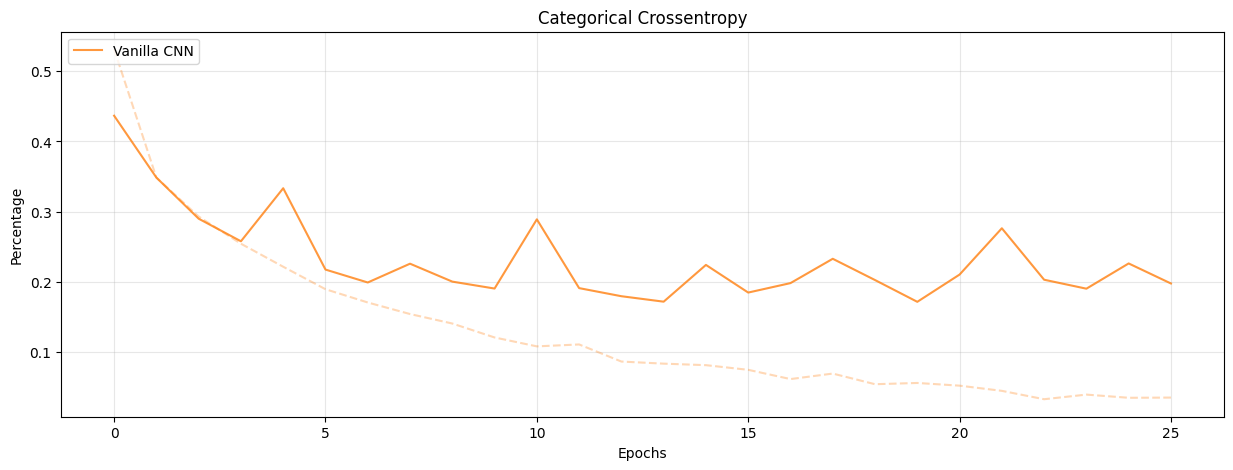

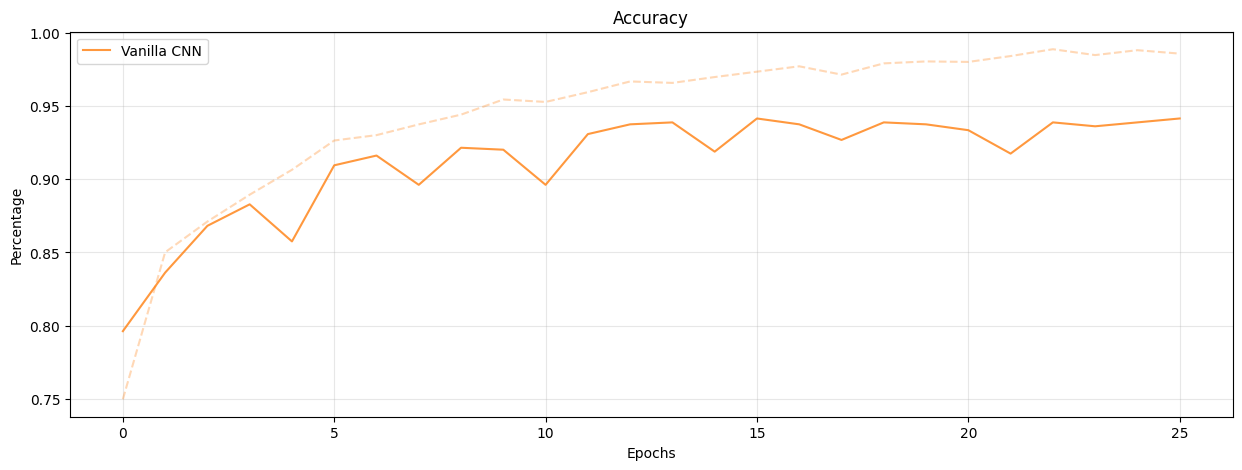

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
import random
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import keras_cv
from keras import layers as tfkl
from tensorflow import keras as tfk
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix


tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

with tf.device('/GPU:0'):
    drive.mount('/gdrive')
    data = np.load('/gdrive/My Drive/Colab Notebooks/clean_dataset.npz', allow_pickle = True)
    images = data['data']
    labels = data['labels']

    # Fix randomness and hide warnings
    seed = 42
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'
    warnings.simplefilter(action='ignore', category=FutureWarning)
    warnings.simplefilter(action='ignore', category=Warning)

    np.random.seed(seed)
    random.seed(seed)

    tf.random.set_seed(seed)

    for i in range(len(labels)):
        if labels[i] == 'healthy':
            labels[i] = 0;
        else:
            labels[i] = 1;

    labels = tfk.utils.to_categorical(labels, num_classes=2)

    img_train_val, img_test, label_train_val, label_test = train_test_split(
        images, labels, random_state=seed, test_size=None, stratify=labels
    )

    img_train, img_val, label_train, label_val = train_test_split(
        img_train_val, label_train_val, random_state=seed, test_size=.20, stratify=label_train_val
    )

    input_shape = img_train.shape[1:]
    output_shape = label_train.shape[1:]
    batch_size = 1
    epochs = 200

    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, mode='auto'),
    ]

    mobile = tfk.applications.ConvNeXtBase(
        model_name="convnext_base",
        include_top=False,
        include_preprocessing=True,
        weights="imagenet",
        input_tensor=None,
        input_shape=(96,96,3),
        pooling="avg",
        classes=2,
        classifier_activation="softmax",
    )
    mobile.trainable = True

    preprocessing = tfk.Sequential([
        tfkl.RandomFlip(),
        tfkl.RandomTranslation(0.2,0.2),
        tfkl.RandomRotation(0.2),
        keras_cv.layers.RandomGaussianBlur(1,factor=(0.2,0.5))
    ])

    input_layer = tfkl.Input(shape=input_shape, name='Input')

    mid_layer = mobile(preprocessing(input_layer))

    output_layer = tfkl.Dense(units=2, activation='softmax',name='Output')(mid_layer)

    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='CNN')

    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics=['accuracy'])

    history = model.fit(
        x = img_train,
        y = label_train,
        batch_size = batch_size,
        epochs = epochs,
        validation_data = (img_val, label_val),
        callbacks = callbacks
    ).history

    plt.figure(figsize=(15,5))
    plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
    plt.plot(history['val_loss'], label='Vanilla CNN', alpha=.8, color='#ff7f0e')
    plt.legend(loc='upper left')
    plt.title('Categorical Crossentropy')
    plt.grid(alpha=.3)
    plt.xlabel('Epochs')
    plt.ylabel('Percentage')

    plt.figure(figsize=(15,5))
    plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
    plt.plot(history['val_accuracy'], label='Vanilla CNN', alpha=.8, color='#ff7f0e')
    plt.legend(loc='upper left')
    plt.title('Accuracy')
    plt.grid(alpha=.3)
    plt.xlabel('Epochs')
    plt.ylabel('Percentage')

    plt.show()

Accuracy: 0.9241
Precision: 0.9299
Recall: 0.9091
F1: 0.9176


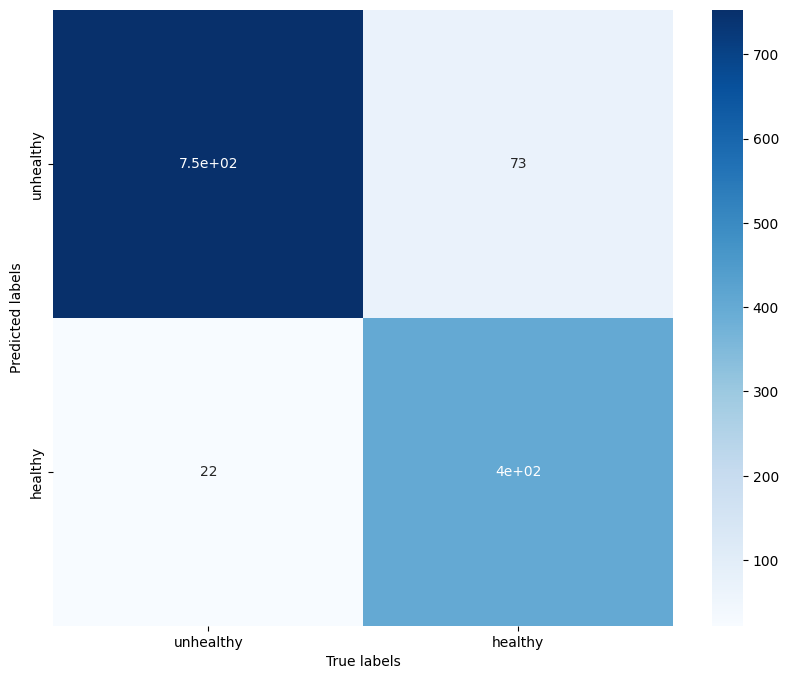

In [4]:
    predictions = model.predict(img_test, verbose=0)
    cm = confusion_matrix(np.argmax(label_test, axis=-1), np.argmax(predictions, axis=-1))
    accuracy = accuracy_score(np.argmax(label_test, axis=-1), np.argmax(predictions, axis=-1))
    precision = precision_score(np.argmax(label_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    recall = recall_score(np.argmax(label_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    f1 = f1_score(np.argmax(label_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    print('Accuracy:', accuracy.round(4))
    print('Precision:', precision.round(4))
    print('Recall:', recall.round(4))
    print('F1:', f1.round(4))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm.T, xticklabels=list(('unhealthy','healthy')), yticklabels=list(('unhealthy','healthy')), cmap='Blues', annot=True)
    plt.xlabel('True labels')
    plt.ylabel('Predicted labels')
    plt.show()

In [5]:
model.save('/gdrive/My Drive/Colab Notebooks/My Model')